In [ ]:
# Code for pulling tweets and classifying the tweets
# author - ADITYA SINGH
# email -singhaditya08aug@gmail.com

In [7]:
# import the dependencies
import keras
from keras import backend as k
import numpy as np
import pandas as pd
import re
import nltk
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
import time
import pickle

In [2]:
# reading the data
train_data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [3]:
# showing the structure of the data
train_data.head(10)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [4]:
# no of rows in the dataset
rows = train_data.count()
print('no of rows in the data set : ', rows[0])

no of rows in the data set :  1599999


In [47]:
# preprocessing the input text
# note that we swithched off the emoji because sentiment140 dataset does not have any emoji
SentimentText = []
def preprocess(train_data):
    i = 0
    while i <rows[0]:
        text =train_data.ix[:,5][i]
        text =text.lower()
        text = re.sub(r'@[A-Za-z0-9]+','',text)
        text = re.sub("[^a-zA-Z]", " ", text)
        #emoji is not present in the dataset
        #text =emoji_pattern.sub(r'', text)
        text = re.sub(r'[^\w\s]','',text)
        text = re.sub(r'(.)\1+', r'\1\1', text)
        tokens = word_tokenize(text)
        new_text =""
        for token in tokens:
            new_text += PorterStemmer().stem(token)
            new_text +=' ' 
        SentimentText.append(new_text)
        
        if i%100000 == 0:
            print('processed :' , i , 'tweets')
        i = i + 1
    print('Done PreProcessing the text' )

In [48]:
# finially calling the preprocessing function
curr_time = time.time()
preprocess(train_data)
new_time = time.time()

time_taken = (new_time - curr_time)/60
print('time taken : ',time_taken, ' mins')

processed : 0 tweets
processed : 100000 tweets
processed : 200000 tweets
processed : 300000 tweets
processed : 400000 tweets
processed : 500000 tweets
processed : 600000 tweets
processed : 700000 tweets
processed : 800000 tweets
processed : 900000 tweets
processed : 1000000 tweets
processed : 1100000 tweets
processed : 1200000 tweets
processed : 1300000 tweets
processed : 1400000 tweets
processed : 1500000 tweets
Done PreProcessing the text
time taken :  26.7050218184789  mins


In [50]:
import pickle
with open("training.1600000.processed.noemoticon.txt", "wb") as fp:
    pickle.dump(SentimentText, fp)

In [5]:
#Finding the unigram representation
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()

# #Finding the bigram representation 
bigram_vectorizer=CountVectorizer(ngram_range=(1,2))

# finding the trigram representation
trigram_vectorizer =CountVectorizer(ngram_range=(1,3))

In [8]:
with open('sentiments/training.1600000.processed.noemoticon.txt', 'rb') as f:
    SentimentText = pickle.load(f)

In [9]:
# our features that we will be using
X_unigrams = vectorizer.fit_transform(SentimentText)
X_bigrams = bigram_vectorizer.fit_transform(SentimentText)
X_trigrams = trigram_vectorizer.fit_transform(SentimentText)

In [10]:
from scipy.sparse import hstack 
X_combined = hstack([X_unigrams , X_bigrams, X_trigrams])

In [11]:
# combined uni_bi+trigrams that showed best performance for ME classifier
X_combined.shape

(1599999, 15503914)

In [12]:
# target values
y =train_data.ix[:,0]

C:\Users\ADITYA\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [13]:
from sklearn import linear_model
model =  linear_model.LogisticRegression(C=1,solver ='saga',penalty = 'l2',max_iter = 50000,n_jobs=4)

In [14]:
# fitting the model on the training data set
model.fit(X_combined,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50000, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

it took me about 30hrs to train this so i didnt have any option to try different model to increase the accuracy so i used ME classifier with uni grams , bi grams and tri grams features that showed best results for previous cases but try for other approached that can increase the accuracy 

In [20]:
#we are saving the model for further use
pkl_filename = "model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)

In [21]:
#now we will run the included pull_tweets.py file to pull the tweets from a paticular hashtag

In [80]:
# reading the tweets file
tweets =pd.read_csv('tweets.csv')
# no of rows in the file
rows = tweets.count()
print('no of rows in the data set : ', rows[0])

no of rows in the data set :  470


In [81]:
# preprocessing the newely aquired tweets
i = 0
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
SentimentText = []
while i <rows[0]:
    text =tweets.ix[:,1][i]
    text =text.lower()
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub("[^a-zA-Z]", " ", text)
    #emoji is not present in the dataset
    text =emoji_pattern.sub(r'', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    tokens = word_tokenize(text)
    new_text =""
    for token in tokens:
        new_text += PorterStemmer().stem(token)
        new_text +=' ' 
    SentimentText.append(new_text)

    if i%100 == 0:
        print('processed :' , i , 'tweets')
    i = i + 1
print('Done PreProcessing the text' )

C:\Users\ADITYA\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


processed : 0 tweets
processed : 100 tweets
processed : 200 tweets
processed : 300 tweets
processed : 400 tweets
Done PreProcessing the text


In [82]:
# now we will extract features from the cleaned text
X_test_unigrams = vectorizer.transform(SentimentText)
X_test_bigrams = bigram_vectorizer.transform(SentimentText)
X_test_trigrams = trigram_vectorizer.transform(SentimentText)

In [83]:
from scipy.sparse import hstack
X_test_combined = hstack([X_test_unigrams , X_test_bigrams,X_test_trigrams])

In [84]:
# checking the shape of the input
X_test_combined.shape

(470, 15503914)

In [85]:
# finally predicting the values
predicted = model.predict(X_test_combined)

In [86]:
#counting the no of 0s 2s and 4s
i = 0
count_0 = 0
count_2 = 0
count_4 = 0
while i<rows[0]:
    if predicted[i] == 0:
        count_0  = count_0 +1
    elif predicted[i] == 2:
        count_2 = count_2 +1
    else:
        count_4 = count_4 +1
    i = i +1

In [87]:
# printing the results for ramdaan
print(count_0)
print(count_2)
print(count_4)

68
0
402


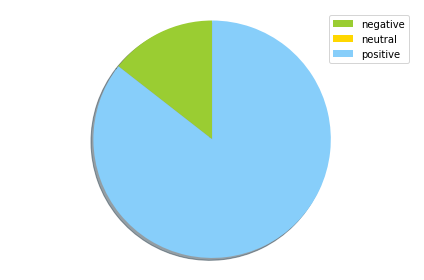

In [88]:
# now we will construct a pie char to visualize the collected data
import matplotlib.pyplot as plt
 
labels = ['negative', 'neutral', 'positive']
sizes = [count_0, count_2, count_4]
colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()


In [90]:
# reading the tweets file
tweets =pd.read_csv('tweets_SaveDemocracy.csv')
# no of rows in the file
rows = tweets.count()
print('no of rows in the data set : ', rows[0])

no of rows in the data set :  3139


In [91]:
# preprocessing the newely aquired tweets
i = 0
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
SentimentText = []
while i <rows[0]:
    text =tweets.ix[:,1][i]
    text =text.lower()
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub("[^a-zA-Z]", " ", text)
    #emoji is not present in the dataset
    text =emoji_pattern.sub(r'', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    tokens = word_tokenize(text)
    new_text =""
    for token in tokens:
        new_text += PorterStemmer().stem(token)
        new_text +=' ' 
    SentimentText.append(new_text)

    if i%1000 == 0:
        print('processed :' , i , 'tweets')
    i = i + 1
print('Done PreProcessing the text' )

C:\Users\ADITYA\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


processed : 0 tweets
processed : 1000 tweets
processed : 2000 tweets
processed : 3000 tweets
Done PreProcessing the text


In [92]:
# now we will extract features from the cleaned text
X_test_unigrams = vectorizer.transform(SentimentText)
X_test_bigrams = bigram_vectorizer.transform(SentimentText)
X_test_trigrams = trigram_vectorizer.transform(SentimentText)

In [93]:
from scipy.sparse import hstack
X_test_combined = hstack([X_test_unigrams , X_test_bigrams,X_test_trigrams])

In [94]:
# checking the shape of the input
X_test_combined.shape

(3139, 15503914)

In [95]:
# finally predicting the values
predicted = model.predict(X_test_combined)

In [97]:
#counting the no of 0s 2s and 4s
i = 0
count_0 = 0
count_2 = 0
count_4 = 0
while i<rows[0]:
    if predicted[i] == 0:
        count_0  = count_0 +1
    elif predicted[i] == 2:
        count_2 = count_2 +1
    else:
        count_4 = count_4 +1
    i = i +1

In [98]:
# printing the results for net neturality
print(count_0)
print(count_2)
print(count_4)

650
0
2489


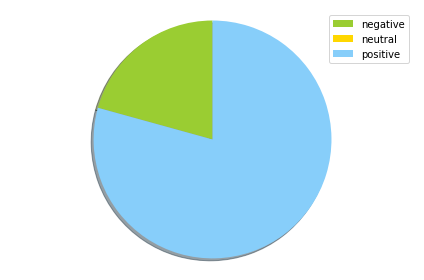

In [99]:
# now we will construct a pie char to visualize the collected data
import matplotlib.pyplot as plt
 
labels = ['negative', 'neutral', 'positive']
sizes = [count_0, count_2, count_4]
colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()